# Assignment1: Prototypical Networks


<center><img src="https://raw.githubusercontent.com/oscarknagg/few-shot/master/assets/proto_nets_diagram.png"/></center>

> Figure 1: Prototypical networks in a nutshell. In a 3-way 5-shot classification task, the class
prototypes c1, c2, c3 are computed from each class’s support features (colored circles). The
prototypes define decision boundaries based on Euclidean distance. A query example $x$
is determined to be class 2 since its features (white circle) lie within that class’s decision
region.


In this assignment, let's use [**prototypical networks**](https://papers.nips.cc/paper/2017/hash/cb8da6767461f2812ae4290eac7cbc42-Abstract.html) to solve the *n-way k-shot few-shot learning* problem with the [Omniglot](https://www.tensorflow.org/datasets/catalog/omniglot) dataset. 

- **IMPORTANT**: 과제 제출하실 때 레포트를 pdf로 변환하고, `Assignment.ipynb`, `dataloader.py`, `model.py`, `train.py`, 모두 압축해서 **이름_학번_Assignment1.zip** 형식으로 ETL에 올리시길 바랍니다.
- Assignment 1 is due 23:59 PM 4/14. Note that 10%p of your score will be deducted for every hour you are late.
- Make sure you are using the latest version of [TensorFlow](https://www.tensorflow.org/api_docs/python/tf), or at least the 2.3 version.
- *If you have any questions regarding the assignment, please contact me at steve2972@snu.ac.kr*

---

## Problem 1

We define a **task** to be an *n-way k-shot* image classification problem. The maximum number of tasks that can be created from a dataset can be defined as $M \choose N$$\cdot$$ K \choose k$ where $M$=the number of classes in the dataset, $N$=the number of classes in a task, $K$=the total number of images in a class, and $k$=the number of shots in a class. In this problem, we define a method to create an upper bound to the number of tasks used during training. 

**Problem**: In the `dataloader.py` file, complete the implementation of the `DataLoader.generate_task_list` method and the `DataLoader.data_generator` method. Details concerning the implementation are as follows:

- The `generate_task_list` method generates a **list of dictionaries** where each dictionary comprises a **task** in the form of `{class_name: [random sequence of image indexes]}`
    - For example, a 2-way 5-shot task for both the support & query datasets can be generated as `{'A': [1,3,5,7,9,2,4,6,8,10], 'B': [8,6,4,10,2,1,5,3,7,9]}`
    - Note that the length of the random sequence of image indexes should equal the # of shots in the support dataset $+$ # of shots in the query dataset.
    
- The `data_generator` method generates a **support** and a **query dataset** where each dataset is in the form of a numpy array with shape `[num_way, num_shot, image_width, image_height, num_channels]`.
    - Note that `data_generator` is created based on tasks which have the form `{class_name: [random sequence of image indexes]}`
    
If the `dataloader.py` file is implemented correctly, the following code should run without error.

In [1]:
from dataloader import DataLoader

num_ways = 5
support_shots = 5
query_shots = 5

train_dataset = DataLoader('train', n_way=num_ways, n_support=support_shots, n_query=query_shots)
val_dataset = DataLoader('test', n_way=num_ways, n_support=support_shots, n_query=query_shots)

/home/mybirth0407/miniconda3/envs/meta_learning/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-04-14 08:19:38.018957: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-14 08:19:39.113863: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7817 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:73:00.0, compute capability: 8.6
2022-04-14 08:19:39.114890: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:lo

Preprocessing train Omniglot dataset
Finished preprocessing
Preprocessing test Omniglot dataset
Finished preprocessing


**If implemented correctly, we can also visualize a random task using the `visualize_random_task` method.**

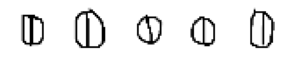

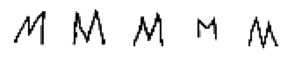

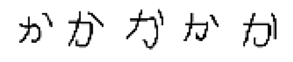

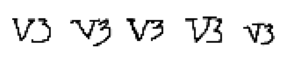

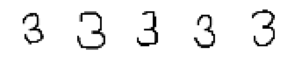

In [2]:
train_dataset.visualize_random_task()

## Problem 2

Next we will implement the prototypical network and examine how the performance of the model changes when **the total number of tasks is changed from 1k to 10k**.

As discussed in the lecture, the basic idea of protonets is to learn a mapping $f_\theta(\cdot)$ from images to features such that images of the same class are close to each other in a feature space. Central to this is the notion of a *prototype*

$$c_n = \frac{1}{K} \sum_{(x,y)\in\mathcal{D}^{tr}_i:y=n} f_\theta(x)$$

i.e. for task $i$, the prototype of the $n$-th class $c_n$ is defined as the mean of the $K$ feature
vectors of that class’s support images. To classify some image $x$, we compute a measure of
distance $d$ between $f_\theta(x)$ and each of the prototypes. We will use the squared Euclidean
distance:

$$d(f_\theta(x),c_n) = ||f_\theta(x) - c_n ||^2_2$$

We interpret the negative squared distances as **logits**, or *unnormalized log-probabilities,
of* $x$ *belonging to each class*. To obtain the proper probabilities, we apply the softmax
operation:

$$p_\theta(y = n|x) = \frac{\exp(-d(f_\theta(x),c_n))}{\sum^N_{n'=1}\exp(-d(f_\theta(x),c_{n'}))}$$

Because the softmax operation preserves ordering, the class whose prototype is closest to
$f_\theta(x)$ is naturally interpreted as the most likely class for $x$. To train the model to generalize,
we compute prototypes using support data, but minimize the negative log likelihood of the query data

$$\mathcal{J}(\theta) = \mathbb{E}_{\mathcal{T}\sim p(\mathcal{T}), (\mathcal{D}^{tr}, \mathcal{D}^{ts})\sim \mathcal{T}} \left[ \frac{1}{NQ} \sum_{(x^{ts},y^{ts})\sim\mathcal{D}^{ts}} -\log p_\theta(y=y^{ts} | x^{ts})\right]$$

Notice that this is equivalent to using a cross-entropy loss.

We optimize $\theta$ using Adam, and as is standard for stochastic gradient methods, we approximate the objective for $\mathcal{J}$ with
Monte Carlo estimation on minibatches of tasks. Thus, for one minibatch of size $B$, we have

$$\mathcal{J}(\theta) \approx \frac{1}{B}\sum_{i=1}^B \left[ \frac{1}{NQ} \sum_{(x^{ts},y^{ts})\sim\mathcal{D}^{ts}} -\log p_\theta(y=y^{ts} | x^{ts})\right]$$


**Problem:**

1. In the `model.py` file, complete the implementation of the `Prototypical_Network.call` method. Pay attention to the inline comments.
2. Test the model with different amounts of training tasks (e.g. from 1k to 10k).
    1.  Create a plot of the validation accuracy using `matplotlib` and report your findings. 
        - Train and validate the model on 5-way 5-shot tasks for both the support and query datasets.
        - [Hint]: you should obtain a query accuracy on the validation split of **at least** 97% with 10k tasks.
    2. Also plot how the degree of overfitting (the difference between training accuracy and validation accuracy) changes with different amounts of tasks.
3. Repeat (2) with different tasks [5way-1shot, 20way-5shot, 20way-1shot] and report your findings


In [3]:
# 1k, 5-way, 5-shot
from dataloader import DataLoader

num_ways = 5
support_shots = 5
query_shots = 5

train_dataset = DataLoader('train', n_way=num_ways, n_support=support_shots, n_query=query_shots)
val_dataset = DataLoader('test', n_way=num_ways, n_support=support_shots, n_query=query_shots)

import train

num_tasks = 1000 # The total number of tasks in the predefined task distribution
num_epochs = 100 # The number of epochs to train the model
num_tasks_per_epoch = 100 # The number of tasks to be trained on for each epoch

# metrics = [train accuracies, train losses, validation accuracies, validation losses]
metrics = train.train_model(
    train_dataset, val_dataset, 
    n_tasks=num_tasks, n_epochs=num_epochs,
    n_tpe=num_tasks_per_epoch
)

Preprocessing train Omniglot dataset
Finished preprocessing
Preprocessing test Omniglot dataset
Finished preprocessing
Epoch1


2022-04-14 08:19:53.030951: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2022-04-14 08:19:54.431184: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


	-Train Loss:0.892 | Train Acc:76.76%
	-Val Loss:0.876 | Val Acc:74.64%
Epoch2
	-Train Loss:0.390 | Train Acc:86.60%
	-Val Loss:0.456 | Val Acc:83.60%
Epoch3
	-Train Loss:0.274 | Train Acc:90.48%
	-Val Loss:0.404 | Val Acc:86.76%
Epoch4
	-Train Loss:0.277 | Train Acc:90.16%
	-Val Loss:0.358 | Val Acc:87.84%
Epoch5
	-Train Loss:0.235 | Train Acc:92.56%
	-Val Loss:0.368 | Val Acc:88.32%
Epoch6
	-Train Loss:0.212 | Train Acc:92.56%
	-Val Loss:0.325 | Val Acc:89.20%
Epoch7
	-Train Loss:0.187 | Train Acc:94.04%
	-Val Loss:0.310 | Val Acc:90.24%
Epoch8
	-Train Loss:0.175 | Train Acc:94.16%
	-Val Loss:0.275 | Val Acc:90.60%
Epoch9
	-Train Loss:0.102 | Train Acc:96.36%
	-Val Loss:0.229 | Val Acc:92.28%
Epoch10
	-Train Loss:0.101 | Train Acc:96.92%
	-Val Loss:0.187 | Val Acc:94.24%
Epoch11
	-Train Loss:0.105 | Train Acc:97.04%
	-Val Loss:0.193 | Val Acc:93.80%
Epoch12
	-Train Loss:0.096 | Train Acc:96.84%
	-Val Loss:0.220 | Val Acc:93.04%
Epoch13
	-Train Loss:0.083 | Train Acc:97.24%
	-Val Loss

<Figure size 1080x720 with 0 Axes>

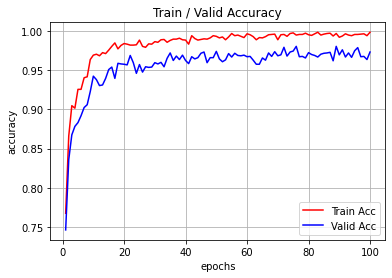

In [4]:
import plot

plot.plot(data1=metrics[0], data2=metrics[2])

In [5]:
# 5k, 5-way, 5-shot
from dataloader import DataLoader

num_ways = 5
support_shots = 5
query_shots = 5

train_dataset = DataLoader('train', n_way=num_ways, n_support=support_shots, n_query=query_shots)
val_dataset = DataLoader('test', n_way=num_ways, n_support=support_shots, n_query=query_shots)

import train

num_tasks = 5000 # The total number of tasks in the predefined task distribution
num_epochs = 100 # The number of epochs to train the model
num_tasks_per_epoch = 100 # The number of tasks to be trained on for each epoch

# metrics = [train accuracies, train losses, validation accuracies, validation losses]
metrics = train.train_model(
    train_dataset, val_dataset, 
    n_tasks=num_tasks, n_epochs=num_epochs,
    n_tpe=num_tasks_per_epoch
)

Preprocessing train Omniglot dataset
Finished preprocessing
Preprocessing test Omniglot dataset
Finished preprocessing
Epoch1
	-Train Loss:0.815 | Train Acc:79.16%
	-Val Loss:0.840 | Val Acc:74.04%
Epoch2
	-Train Loss:0.433 | Train Acc:85.28%
	-Val Loss:0.445 | Val Acc:83.64%
Epoch3
	-Train Loss:0.281 | Train Acc:90.80%
	-Val Loss:0.370 | Val Acc:86.76%
Epoch4
	-Train Loss:0.241 | Train Acc:91.00%
	-Val Loss:0.312 | Val Acc:88.28%
Epoch5
	-Train Loss:0.201 | Train Acc:93.32%
	-Val Loss:0.256 | Val Acc:91.96%
Epoch6
	-Train Loss:0.176 | Train Acc:94.28%
	-Val Loss:0.190 | Val Acc:93.92%
Epoch7
	-Train Loss:0.109 | Train Acc:96.68%
	-Val Loss:0.193 | Val Acc:93.12%
Epoch8
	-Train Loss:0.107 | Train Acc:96.56%
	-Val Loss:0.173 | Val Acc:95.56%
Epoch9
	-Train Loss:0.115 | Train Acc:96.64%
	-Val Loss:0.175 | Val Acc:94.04%
Epoch10
	-Train Loss:0.095 | Train Acc:96.88%
	-Val Loss:0.199 | Val Acc:93.44%
Epoch11
	-Train Loss:0.138 | Train Acc:95.80%
	-Val Loss:0.164 | Val Acc:95.48%
Epoch12
	-

<Figure size 1080x720 with 0 Axes>

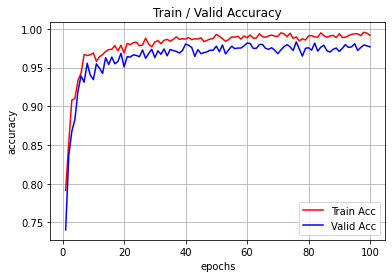

In [6]:
plot.plot(data1=metrics[0], data2=metrics[2])

In [7]:
# 10k, 5-way, 5-shot
from dataloader import DataLoader

num_ways = 5
support_shots = 5
query_shots = 5

train_dataset = DataLoader('train', n_way=num_ways, n_support=support_shots, n_query=query_shots)
val_dataset = DataLoader('test', n_way=num_ways, n_support=support_shots, n_query=query_shots)

import train

num_tasks = 10000 # The total number of tasks in the predefined task distribution
num_epochs = 100 # The number of epochs to train the model
num_tasks_per_epoch = 100 # The number of tasks to be trained on for each epoch

# metrics = [train accuracies, train losses, validation accuracies, validation losses]
metrics = train.train_model(
    train_dataset, val_dataset, 
    n_tasks=num_tasks, n_epochs=num_epochs,
    n_tpe=num_tasks_per_epoch
)

Preprocessing train Omniglot dataset
Finished preprocessing
Preprocessing test Omniglot dataset
Finished preprocessing
Epoch1
	-Train Loss:0.802 | Train Acc:79.68%
	-Val Loss:0.833 | Val Acc:75.44%
Epoch2
	-Train Loss:0.380 | Train Acc:87.88%
	-Val Loss:0.464 | Val Acc:83.56%
Epoch3
	-Train Loss:0.324 | Train Acc:90.12%
	-Val Loss:0.359 | Val Acc:88.08%
Epoch4
	-Train Loss:0.215 | Train Acc:92.76%
	-Val Loss:0.309 | Val Acc:89.08%
Epoch5
	-Train Loss:0.164 | Train Acc:94.96%
	-Val Loss:0.245 | Val Acc:92.16%
Epoch6
	-Train Loss:0.172 | Train Acc:94.56%
	-Val Loss:0.240 | Val Acc:92.20%
Epoch7
	-Train Loss:0.103 | Train Acc:96.20%
	-Val Loss:0.207 | Val Acc:93.48%
Epoch8
	-Train Loss:0.157 | Train Acc:95.92%
	-Val Loss:0.171 | Val Acc:93.68%
Epoch9
	-Train Loss:0.119 | Train Acc:96.24%
	-Val Loss:0.173 | Val Acc:94.20%
Epoch10
	-Train Loss:0.107 | Train Acc:96.84%
	-Val Loss:0.151 | Val Acc:95.16%
Epoch11
	-Train Loss:0.086 | Train Acc:96.84%
	-Val Loss:0.141 | Val Acc:95.68%
Epoch12
	-

<Figure size 1080x720 with 0 Axes>

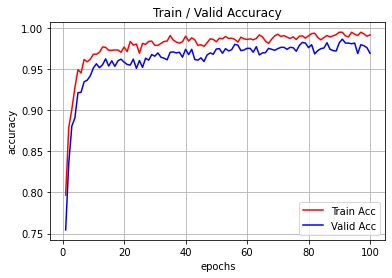

In [8]:
plot.plot(data1=metrics[0], data2=metrics[2])

In [9]:
# 10k, 5-way, 1-shot
from dataloader import DataLoader

num_ways = 5
support_shots = 1
query_shots = 5

train_dataset = DataLoader('train', n_way=num_ways, n_support=support_shots, n_query=query_shots)
val_dataset = DataLoader('test', n_way=num_ways, n_support=support_shots, n_query=query_shots)

import train

num_tasks = 10000 # The total number of tasks in the predefined task distribution
num_epochs = 100 # The number of epochs to train the model
num_tasks_per_epoch = 100 # The number of tasks to be trained on for each epoch

# metrics = [train accuracies, train losses, validation accuracies, validation losses]
metrics = train.train_model(
    train_dataset, val_dataset, 
    n_tasks=num_tasks, n_epochs=num_epochs,
    n_tpe=num_tasks_per_epoch
)

Preprocessing train Omniglot dataset
Finished preprocessing
Preprocessing test Omniglot dataset
Finished preprocessing
Epoch1
	-Train Loss:1.071 | Train Acc:66.48%
	-Val Loss:1.115 | Val Acc:60.72%
Epoch2
	-Train Loss:0.681 | Train Acc:76.60%
	-Val Loss:0.754 | Val Acc:71.92%
Epoch3
	-Train Loss:0.560 | Train Acc:80.52%
	-Val Loss:0.702 | Val Acc:75.32%
Epoch4
	-Train Loss:0.624 | Train Acc:76.60%
	-Val Loss:0.756 | Val Acc:75.20%
Epoch5
	-Train Loss:0.482 | Train Acc:84.24%
	-Val Loss:0.605 | Val Acc:78.20%
Epoch6
	-Train Loss:0.540 | Train Acc:79.16%
	-Val Loss:0.677 | Val Acc:76.04%
Epoch7
	-Train Loss:0.472 | Train Acc:84.28%
	-Val Loss:0.652 | Val Acc:77.32%
Epoch8
	-Train Loss:0.434 | Train Acc:84.80%
	-Val Loss:0.622 | Val Acc:79.56%
Epoch9
	-Train Loss:0.397 | Train Acc:86.60%
	-Val Loss:0.546 | Val Acc:81.12%
Epoch10
	-Train Loss:0.316 | Train Acc:89.64%
	-Val Loss:0.501 | Val Acc:81.32%
Epoch11
	-Train Loss:0.293 | Train Acc:89.92%
	-Val Loss:0.401 | Val Acc:85.84%
Epoch12
	-

<Figure size 1080x720 with 0 Axes>

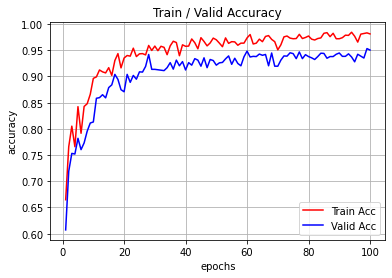

In [10]:
plot.plot(data1=metrics[0], data2=metrics[2])

In [11]:
# 10k, 20-way, 5-shot
from dataloader import DataLoader

num_ways = 20
support_shots = 5
query_shots = 5

train_dataset = DataLoader('train', n_way=num_ways, n_support=support_shots, n_query=query_shots)
val_dataset = DataLoader('test', n_way=num_ways, n_support=support_shots, n_query=query_shots)

import train

num_tasks = 10000 # The total number of tasks in the predefined task distribution
num_epochs = 100 # The number of epochs to train the model
num_tasks_per_epoch = 100 # The number of tasks to be trained on for each epoch

# metrics = [train accuracies, train losses, validation accuracies, validation losses]
metrics = train.train_model(
    train_dataset, val_dataset, 
    n_tasks=num_tasks, n_epochs=num_epochs,
    n_tpe=num_tasks_per_epoch
)

Preprocessing train Omniglot dataset
Finished preprocessing
Preprocessing test Omniglot dataset
Finished preprocessing
Epoch1
	-Train Loss:1.570 | Train Acc:60.54%
	-Val Loss:1.644 | Val Acc:55.25%
Epoch2
	-Train Loss:0.650 | Train Acc:80.61%
	-Val Loss:0.815 | Val Acc:75.07%
Epoch3
	-Train Loss:0.407 | Train Acc:87.55%
	-Val Loss:0.521 | Val Acc:84.55%
Epoch4
	-Train Loss:0.257 | Train Acc:92.05%
	-Val Loss:0.367 | Val Acc:89.54%
Epoch5
	-Train Loss:0.197 | Train Acc:94.31%
	-Val Loss:0.330 | Val Acc:90.17%
Epoch6
	-Train Loss:0.167 | Train Acc:94.61%
	-Val Loss:0.285 | Val Acc:91.08%
Epoch7
	-Train Loss:0.154 | Train Acc:95.28%
	-Val Loss:0.254 | Val Acc:92.18%
Epoch8
	-Train Loss:0.136 | Train Acc:95.66%
	-Val Loss:0.269 | Val Acc:92.22%
Epoch9
	-Train Loss:0.140 | Train Acc:95.60%
	-Val Loss:0.268 | Val Acc:92.07%
Epoch10
	-Train Loss:0.120 | Train Acc:96.06%
	-Val Loss:0.225 | Val Acc:92.78%
Epoch11
	-Train Loss:0.102 | Train Acc:96.72%
	-Val Loss:0.246 | Val Acc:92.95%
Epoch12
	-

<Figure size 1080x720 with 0 Axes>

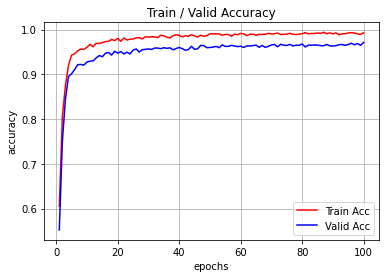

In [12]:
plot.plot(data1=metrics[0], data2=metrics[2])

In [13]:
# 10k, 20-way, 1-shot
from dataloader import DataLoader

num_ways = 20
support_shots = 1
query_shots = 5

train_dataset = DataLoader('train', n_way=num_ways, n_support=support_shots, n_query=query_shots)
val_dataset = DataLoader('test', n_way=num_ways, n_support=support_shots, n_query=query_shots)

import train

num_tasks = 10000 # The total number of tasks in the predefined task distribution
num_epochs = 100 # The number of epochs to train the model
num_tasks_per_epoch = 100 # The number of tasks to be trained on for each epoch

# metrics = [train accuracies, train losses, validation accuracies, validation losses]
metrics = train.train_model(
    train_dataset, val_dataset, 
    n_tasks=num_tasks, n_epochs=num_epochs,
    n_tpe=num_tasks_per_epoch
)

Preprocessing train Omniglot dataset
Finished preprocessing
Preprocessing test Omniglot dataset
Finished preprocessing
Epoch1
	-Train Loss:2.059 | Train Acc:43.63%
	-Val Loss:2.107 | Val Acc:39.60%
Epoch2
	-Train Loss:1.326 | Train Acc:60.11%
	-Val Loss:1.521 | Val Acc:53.18%
Epoch3
	-Train Loss:0.923 | Train Acc:72.06%
	-Val Loss:1.167 | Val Acc:64.53%
Epoch4
	-Train Loss:0.647 | Train Acc:80.68%
	-Val Loss:0.871 | Val Acc:73.74%
Epoch5
	-Train Loss:0.521 | Train Acc:84.26%
	-Val Loss:0.760 | Val Acc:77.69%
Epoch6
	-Train Loss:0.436 | Train Acc:86.16%
	-Val Loss:0.694 | Val Acc:79.30%
Epoch7
	-Train Loss:0.407 | Train Acc:87.61%
	-Val Loss:0.636 | Val Acc:80.18%
Epoch8
	-Train Loss:0.329 | Train Acc:89.57%
	-Val Loss:0.588 | Val Acc:82.49%
Epoch9
	-Train Loss:0.330 | Train Acc:89.98%
	-Val Loss:0.576 | Val Acc:83.03%
Epoch10
	-Train Loss:0.298 | Train Acc:90.10%
	-Val Loss:0.583 | Val Acc:82.38%
Epoch11
	-Train Loss:0.287 | Train Acc:91.04%
	-Val Loss:0.588 | Val Acc:82.89%
Epoch12
	-

<Figure size 1080x720 with 0 Axes>

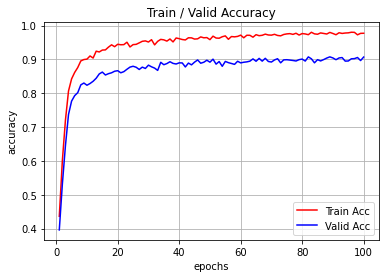

In [14]:
plot.plot(data1=metrics[0], data2=metrics[2])

## Problem 3

Finally, we will evaluate the generalization performance of the model by using a **different test setting from a training setting**.

<br>

As prototypical networks are based on a nonparametric method, we can flexibly train the model with different types of tasks (e.g. 5way1shot tasks + 5way5shot tasks). Let's assume we are allowed to use up to 30 training samples to train a single task. Evaluate the performance of the model when we train the model using **randomly defined training tasks**.



**Problem**:

1. In the `dataloader.py` file, implement the `random_data_generator` method.
2. Using the experimental details outlined below, run experiments and compare with the results from Problem 2
    - Note that you do not need to specify a set number of tasks for this problem


**Experimental Details**:
- *Train setting*: Assume to use exactly 30 images for each task (for support + query). First randomly select $N$ from the set $\{2, 3, 5, 6, 10, 15\}$. This means that each $N$ can use $\{15, 10, 6, 5, 3, 2\}$ samples per class respectively. By properly splitting the number of samples into 2 splits (support/query), we can randomly define different tasks.
    - For example, an example support/query task can be defined as support={5-way 4-shot}, and query={5-way 2-shot}.
    - *Extra Credit (optional)*: implement and test a method where we use a flexible number of images (not limited to just 30) where $N$ can also be defined randomly.
- *Test setting*: 5way 5 shot (5$\cdot$5 for support + 5$\cdot$1 for query = 30 images)


In [20]:
num_ways = 5
support_shots = 5
query_shots = 1

train_dataset = DataLoader('train')
val_dataset = DataLoader('test', n_way=num_ways, n_support=support_shots, n_query=query_shots)

Preprocessing train Omniglot dataset
Finished preprocessing
Preprocessing test Omniglot dataset
Finished preprocessing


In [21]:
num_epochs = 100 # The number of epochs to train the model
num_tasks_per_epoch = 100 # The number of tasks to be trained on for each epoch

# metrics = [train accuracies, train losses, validation accuracies, validation losses]
metrics = train.train_model(train_dataset, val_dataset,
                            n_tasks=num_tasks, n_epochs=num_epochs,
                            n_tpe=num_tasks_per_epoch, is_random=True)

Epoch1
	-Train Loss:0.930 | Train Acc:74.46%
	-Val Loss:0.905 | Val Acc:72.80%
Epoch2
	-Train Loss:0.586 | Train Acc:82.38%
	-Val Loss:0.489 | Val Acc:84.60%
Epoch3
	-Train Loss:0.459 | Train Acc:85.49%
	-Val Loss:0.477 | Val Acc:83.40%
Epoch4
	-Train Loss:0.370 | Train Acc:88.46%
	-Val Loss:0.417 | Val Acc:84.00%
Epoch5
	-Train Loss:0.375 | Train Acc:88.10%
	-Val Loss:0.420 | Val Acc:88.00%
Epoch6
	-Train Loss:0.355 | Train Acc:88.39%
	-Val Loss:0.305 | Val Acc:88.60%
Epoch7
	-Train Loss:0.305 | Train Acc:91.09%
	-Val Loss:0.335 | Val Acc:88.00%
Epoch8
	-Train Loss:0.315 | Train Acc:90.09%
	-Val Loss:0.310 | Val Acc:91.20%
Epoch9
	-Train Loss:0.243 | Train Acc:92.37%
	-Val Loss:0.267 | Val Acc:90.20%
Epoch10
	-Train Loss:0.351 | Train Acc:88.81%
	-Val Loss:0.335 | Val Acc:88.60%
Epoch11
	-Train Loss:0.304 | Train Acc:90.71%
	-Val Loss:0.284 | Val Acc:92.40%
Epoch12
	-Train Loss:0.169 | Train Acc:94.31%
	-Val Loss:0.211 | Val Acc:93.40%
Epoch13
	-Train Loss:0.190 | Train Acc:94.23%
	-V

<Figure size 1080x720 with 0 Axes>

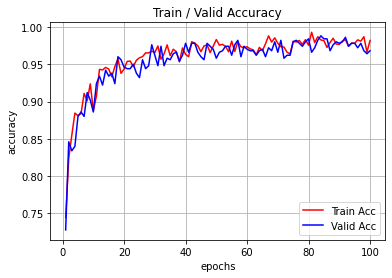

In [22]:
plot.plot(data1=metrics[0], data2=metrics[2])

## Extra Credit (Optional)

In [23]:
import random

num_epochs = 100 # The number of epochs to train the model
num_tasks_per_epoch = 100 # The number of tasks to be trained on for each epoch

random_way = random.randrange(1, 10) # random N-way generator
print(f'{random_way}-way task')
# metrics = [train accuracies, train losses, validation accuracies, validation losses]
metrics = train.train_model(train_dataset, val_dataset,
                            n_tasks=num_tasks, n_epochs=num_epochs,
                            n_tpe=num_tasks_per_epoch, random_way=random_way,
                            is_random=True)

3-way task
Epoch1
	-Train Loss:0.640 | Train Acc:82.00%
	-Val Loss:1.054 | Val Acc:70.40%
Epoch2
	-Train Loss:0.363 | Train Acc:86.61%
	-Val Loss:0.513 | Val Acc:82.40%
Epoch3
	-Train Loss:0.265 | Train Acc:89.35%
	-Val Loss:0.454 | Val Acc:82.40%
Epoch4
	-Train Loss:0.262 | Train Acc:90.30%
	-Val Loss:0.441 | Val Acc:85.20%
Epoch5
	-Train Loss:0.246 | Train Acc:92.73%
	-Val Loss:0.411 | Val Acc:87.40%
Epoch6
	-Train Loss:0.222 | Train Acc:92.62%
	-Val Loss:0.389 | Val Acc:87.80%
Epoch7
	-Train Loss:0.260 | Train Acc:91.46%
	-Val Loss:0.407 | Val Acc:87.20%
Epoch8
	-Train Loss:0.205 | Train Acc:92.81%
	-Val Loss:0.441 | Val Acc:86.20%
Epoch9
	-Train Loss:0.204 | Train Acc:93.84%
	-Val Loss:0.571 | Val Acc:85.40%
Epoch10
	-Train Loss:0.214 | Train Acc:92.55%
	-Val Loss:0.429 | Val Acc:85.80%
Epoch11
	-Train Loss:0.246 | Train Acc:91.22%
	-Val Loss:0.365 | Val Acc:86.80%
Epoch12
	-Train Loss:0.243 | Train Acc:92.36%
	-Val Loss:0.359 | Val Acc:87.80%
Epoch13
	-Train Loss:0.266 | Train Acc

<Figure size 1080x720 with 0 Axes>

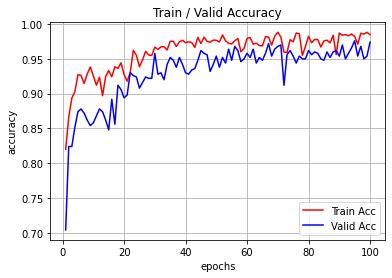

In [24]:
plot.plot(data1=metrics[0], data2=metrics[2])